# Use Cases for Model Insights
**Why and when do you need insights?**

## What Types of Insights Are Possible
Many people say machine learning models are "black boxes", in the sense that they can make good predictions but you can't understand the logic behind those predictions. This statement is true in the sense that most data scientists don't know how to extract insights from models yet.

However, wen will go through some techniques to extract the following insights from sophisticated machine learning models.

- What features in the data did the model think are most important?
- For any single prediction from a model, how did each feature in the data affect that particular prediction?
- How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)?

## Why Are These Insights Valuable
These insights have many uses, including

- Debugging
- Informing feature engineering
- Directing future data collection
- Informing human decision-making
- Building Trust

### Debugging

The world has a lot of unreliable, disorganized and generally dirty data. You add a potential source of errors as you write preprocessing code. Add in the potential for [target leakage](https://www.kaggle.com/code/alexisbcook/data-leakage), and it is the norm rather than the exception to have errors at some point in a real data science project.

Given the frequency and potentially disastrous consequences of bugs, debugging is one of the most valuable skills in data science. Understanding the patterns a model is finding will help you identify when those are at odds with your knowledge of the real world, and this is typically the first step in tracking down bugs.

### Informing Feature Engineering

[Feature engineering](https://www.kaggle.com/learn/feature-engineering) is usually the most effective way to improve model accuracy. Feature engineering usually involves repeatedly creating new features using transformations of your raw data or features you have previously created.

Sometimes you can go through this process using nothing but intuition about the underlying topic. But you'll need more direction when you have 100s of raw features or when you lack background knowledge about the topic you are working on.

A Kaggle competition to predict [loan defaults](https://www.kaggle.com/c/loan-default-prediction) gives an extreme example. This competition had 100s of raw features. For privacy reasons, the features had names like f1, f2, f3 rather than common English names. This simulated a scenario where you have little intuition about the raw data.

One competitor found that the difference between two of the features, specifically f527 - f528, created a very powerful new feature. Models including that difference as a feature were far better than models without it. But how might you think of creating this variable when you start with hundreds of variables?

The techniques you'll see in this micro-course would make it transparent that f527 and f528 are important features, and that their role is tightly entangled. This will direct you to consider transformations of these two variables, and likely find the "golden feature" of f527 - f528.

As an increasing number of datasets start with 100s or 1000s of raw features, this approach is becoming increasingly important.

### Directing Future Data Collection

You have no control over datasets you download online. But many businesses and organizations using data science have opportunities to expand what types of data they collect. Collecting new types of data can be expensive or inconvenient, so they only want to do this if they know it will be worthwhile. Model-based insights give you a good understanding of the value of features you currently have, which will help you reason about what new values may be most helpful.

### Informing Human Decision-Making

Some decisions are made automatically by models. Amazon doesn't have humans (or elves) scurry to decide what to show you whenever you go to their website. But many important decisions are made by humans. For these decisions, insights can be more valuable than predictions.

### Building Trust

Many people won't assume they can trust your model for important decisions without verifying some basic facts. This is a smart precaution given the frequency of data errors. In practice, showing insights that fit their general understanding of the problem will help build trust, even among people with little deep knowledge of data science.

# Permutation Importance
**What features does your model think are important?**

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called **feature importance**.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

Below, we'll focus on **permutation importance**. Compared to most other approaches, permutation importance is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

## How It Works
Permutation importance uses models differently than anything you've seen so far, and many people find it confusing at first. So we'll start with an example to make it more concrete.

Consider data with the following format:

|Height at age 20 (cm)|Height at age 10 (cm)|    ...    |Socks owned at age 10|
|---------------------|---------------------|--------------|---------------------|
|182|155|    ...    |20|
|175|147|    ...    |10|
|...|...|    ...    |...|
|156|142|    ...    |8|
|153|130|    ...    |24|

We want to predict a person's height when they become 20 years old, using data that is available at age 10.

Our data includes useful features (height at age 10), features with little predictive power (socks owned), as well as some other features we won't focus on in this explanation.

**Permutation importance is calculated after a model has been fitted**. So we won't change the model or change what predictions we'd get for a given value of height, sock-count, etc.

Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?

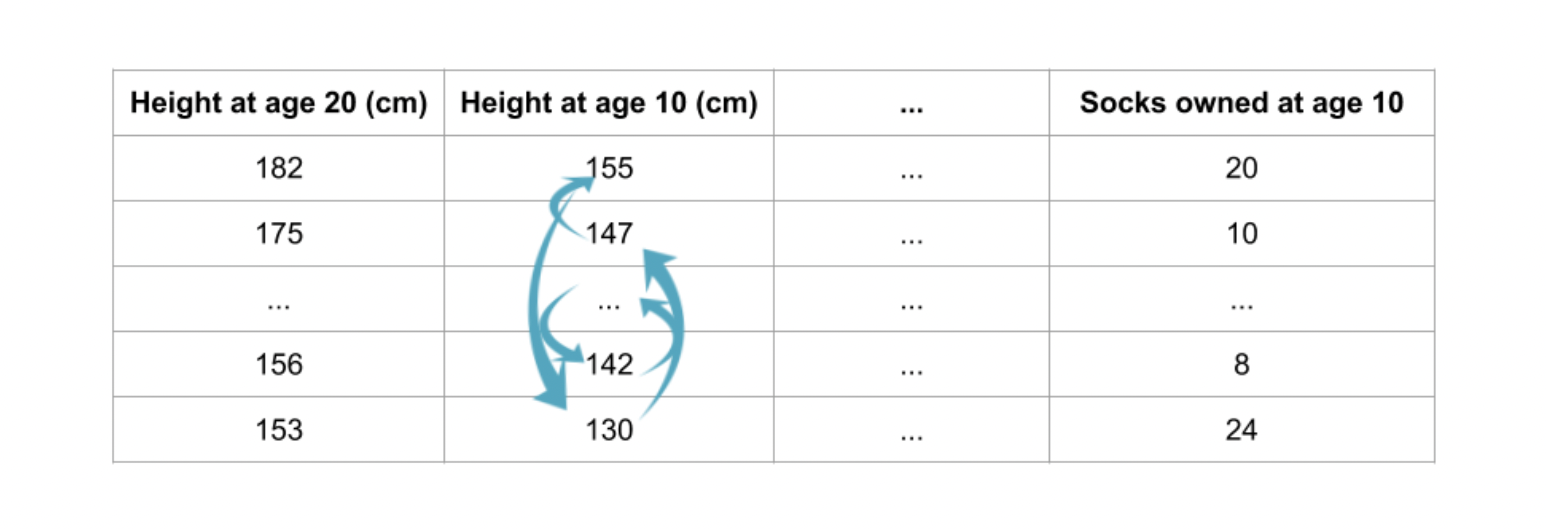

In [2]:
from IPython.display import Image
Image('/Users/tusharrao/Downloads/Per.png')

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions. In this case, shuffling height at age 10 would cause terrible predictions. If we shuffled socks owned instead, the resulting predictions wouldn't suffer nearly as much.

With this insight, the process is as follows:

1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

## Code Example
Our example will use a model that predicts whether a soccer/football team will have the "Man of the Game" winner based on the team's statistics. The "Man of the Game" award is given to the best player in the game.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('/Users/tusharrao/Downloads/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library:

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


## Interpreting Permutation Importances
The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the **±** measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **Goals scored**. That seems sensible. Soccer fans may have some intuition about whether the orderings of other variables are surprising or not.

# Partial Plots
**How does each feature affect your predictions?**

## Partial Dependence Plots
While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

This is useful to answer questions like:

- Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

- Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models. If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.